# Introduction, data cleaning, and EDA

For this project, all data is taken from one or more images, each of which has been split into a number of smaller pieces along a regular grid. The dimensions of this grid may be as many as $30$X$30$, making a total of $900$ parts. The goal is to make use of unsupervised and possibly supervised machine learning approaches in order to reconstruct the original image from its constituent parts.

Here is the image used:

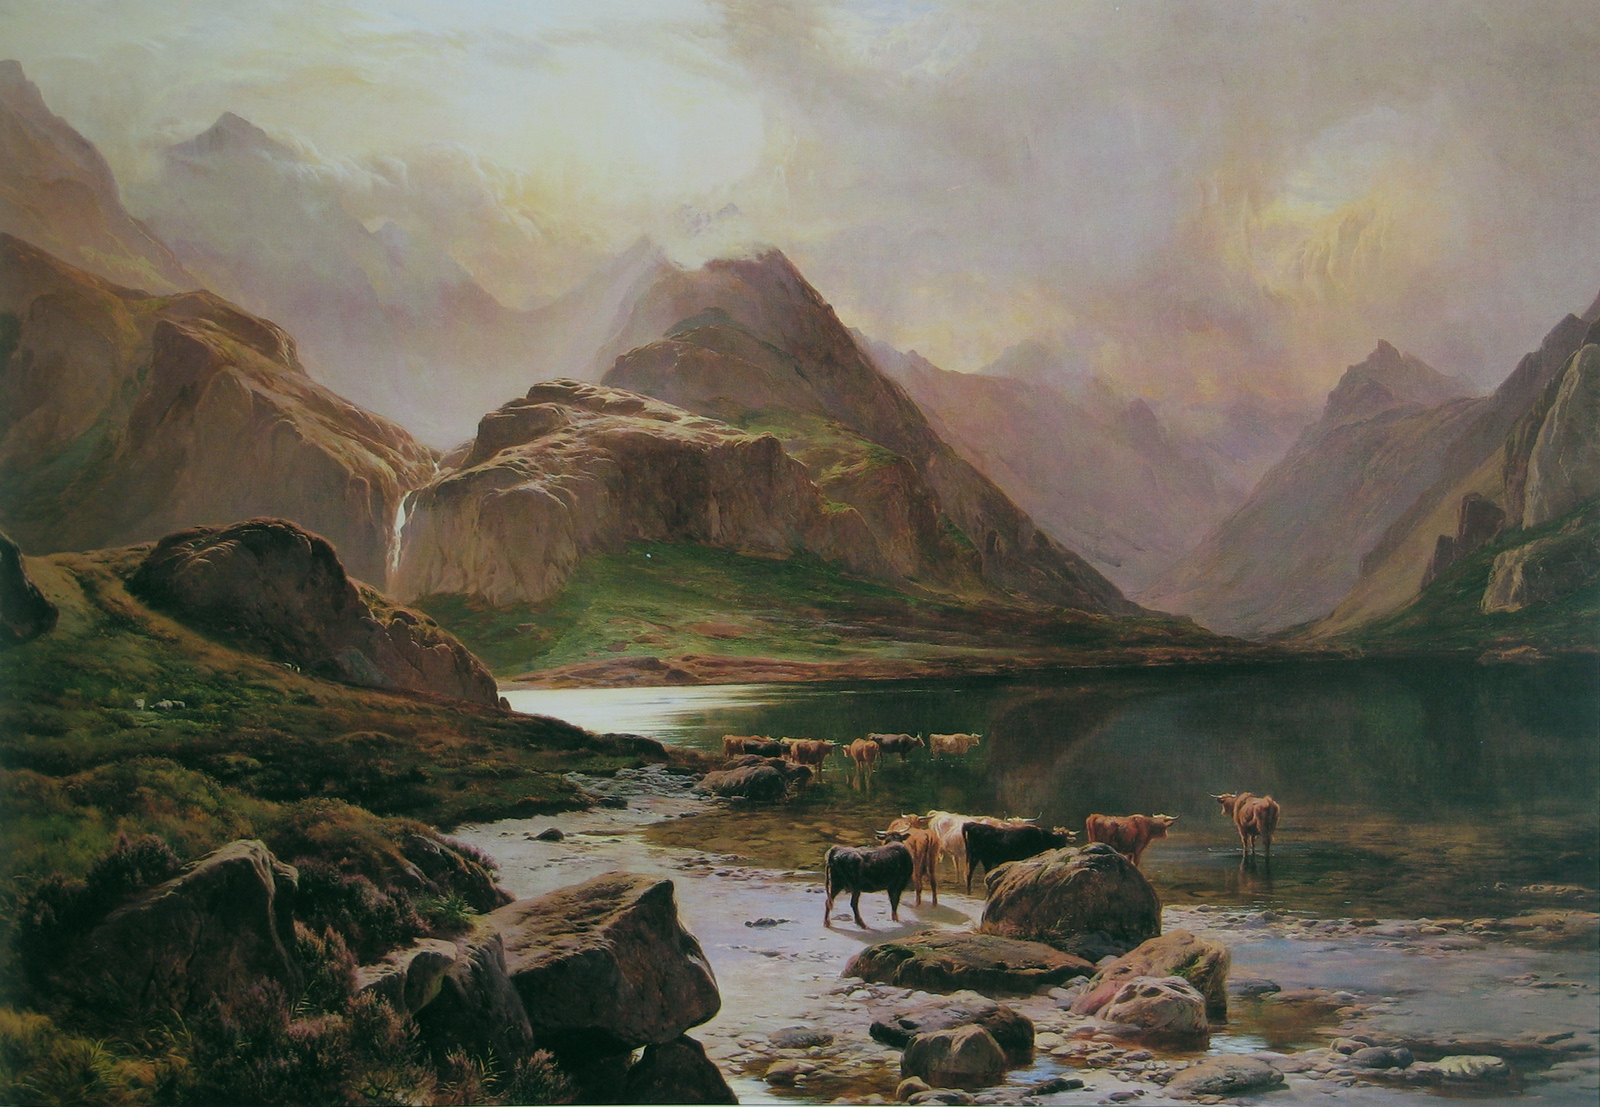

First, it is necessary to load the data and vectorize it so analysis can begin. Each image part will be treated as a single observation. For each observation, the average RGB values of the pixels will be determined. Each observation will then have three non-negative numerical features: one for the average amount of red, one for green, and one for blue.

In [1]:
from PIL import Image
import numpy as np

def getPixArrays(pix, size, mode):
    
    width = size[0]
    height = size[1]
    
    pixr = np.zeros((height,width))
    pixg = np.zeros((height,width))
    pixb = np.zeros((height,width))
    
    for i in range(height):
        for j in range(width):
            if mode == "L":
                pixr[i,j] = pix[j,i]
                pixg[i,j] = pix[j,i]
                pixb[i,j] = pix[j,i]
            else:
                pixr[i,j] = pix[j,i][0]
                pixg[i,j] = pix[j,i][1]
                pixb[i,j] = pix[j,i][2]
    
    return (pixr, pixg, pixb)

def getAverages(pixr, pixg, pixb):
    
    return np.mean(pixr), np.mean(pixg), np.mean(pixb)

n_features = 3
Xtrain = np.zeros((900, n_features))

for i in range(1,901):
    imgname = f"img/image_part_{i:03d}.jpg"
    im = Image.open(imgname)
    pix = im.load()
    size = im.size
    mode = im.mode
    pixr, pixg, pixb = getPixArrays(pix, size, mode)
    Xtrain[i-1] = getAverages(pixr,pixg,pixb)

Below are histograms of each of the three features.

Text(0.5, 1.0, 'Average red pixel values')

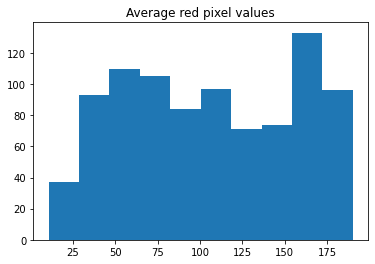

In [2]:
import matplotlib.pyplot as plt

plt.hist(Xtrain[:,0])
plt.title("Average red pixel values")

Text(0.5, 1.0, 'Average green pixel values')

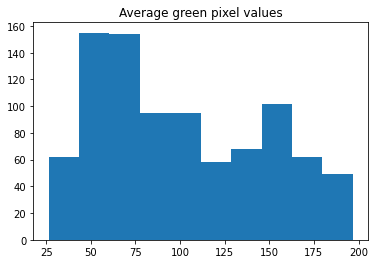

In [3]:
plt.hist(Xtrain[:,1])
plt.title("Average green pixel values")

Text(0.5, 1.0, 'Average blue pixel values')

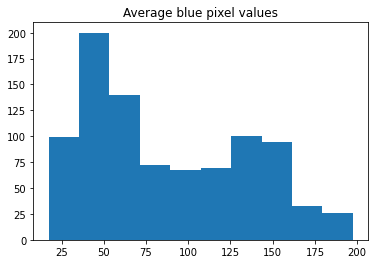

In [4]:
plt.hist(Xtrain[:,2])
plt.title("Average blue pixel values")

In [5]:
np.corrcoef(Xtrain, rowvar=False)

array([[1.        , 0.97910464, 0.96122153],
       [0.97910464, 1.        , 0.98966768],
       [0.96122153, 0.98966768, 1.        ]])

Based on the histograms, the distribution of each feature appears to be similar. It can also be seen based on the correlation coefficients that the features are very highly correlated with one another. Since I will be beginning with clustering methods, this should not be an issue, however.

I already processed the data for my particular purposes, so there should be no need for transformation or cleaning of the data.

# Model training and analysis

In [6]:
from sklearn.cluster import KMeans

n_clusters = 16

fitted = KMeans(n_clusters=n_clusters).fit_transform(Xtrain)

Above I have fitted a K-means clustering model to the data. I will run a number of models with different numbers of clusters to see how the performance changes.

The code below takes the appropriate image parts based on the cluster model and pastes them together. The pasting together of clusters is not done in a systematic way and is ultimately not important for the evalulation of the model, but is done partly arbitrarily and partly subjectively to gain a simple intuitive understanding of the model's performance.

In [7]:
import os
import shutil

cluster_indexes = []

for i in range(n_clusters):
    os.makedirs(f"img/{i:d}")
    cluster_indexes.append([])

for index, fit in enumerate(fitted):
    cluster = list(fit).index(np.min(fit))
    shutil.copyfile(f"img/image_part_{(index+1):03d}.jpg", f"img/{cluster:d}/image_part_{(index+1):03d}.jpg")
    cluster_indexes[cluster].append(index+1)

In [8]:
for i in range(n_clusters):

    to_paste = os.listdir(f"{i:d}")

    if n_clusters == 16:
        blank_image = Image.open("clustered_imgs/blank16.png")
    elif n_clusters == 4:
        blank_image = Image.open("clustered_imgs/blank.png")


    index = 0
    row = 0
    col = 0
    for img in to_paste:
        if n_clusters == 16:
            if row > 6:
                break
            if col > 7:
                col = 0
                row += 1
        elif n_clusters == 4:
            if row > 15:
                break
            if col > 15:
                col = 0
                row += 1
        blank_image.paste(Image.open(img), (col*53,row*37))
        col += 1
    blank_image.save(f"clustered_imgs/{i:d}.png")

Testing the accuracy of the model could be challenging, since the original data does not exist in classes or clusters, so there is not an obvious way to check if the clusters are correct. To test the accuracy of the algorithm, I will make use of the fact that each image part is numbered in order. Therefore, parts which are closer together in the original ought to, on average, have numbers which are more similar. So, by taking a weighted average of the variances of these numbers in each cluster, it should be possible to determine how similar the constructed image is to the original. The lower this score is, the more accurate the model.

It should be noted that potential issues of using this metric is the difficulty in comparisons with other types of models, as well as difficulty in interpretability. It is also possible that the score could be unevenly impacted by the size of the clusters.

In [11]:
variances = []
w = []

for cluster in cluster_indexes:
    variances.append(np.var(cluster))
    w.append(len(cluster)/900)
    
var_sum = 0
for cluster, var in enumerate(variances):
    var_sum += w[cluster]*var
var_score = (var_sum / np.sum(w))

score for n_clusters = 16: $27361$

score for n_clusters = 4: $32909$

Based on the scores obtained, it can be seen that increasing the number of clusters improves the performance of the model.

Here is the constructed image for 4 clusters:
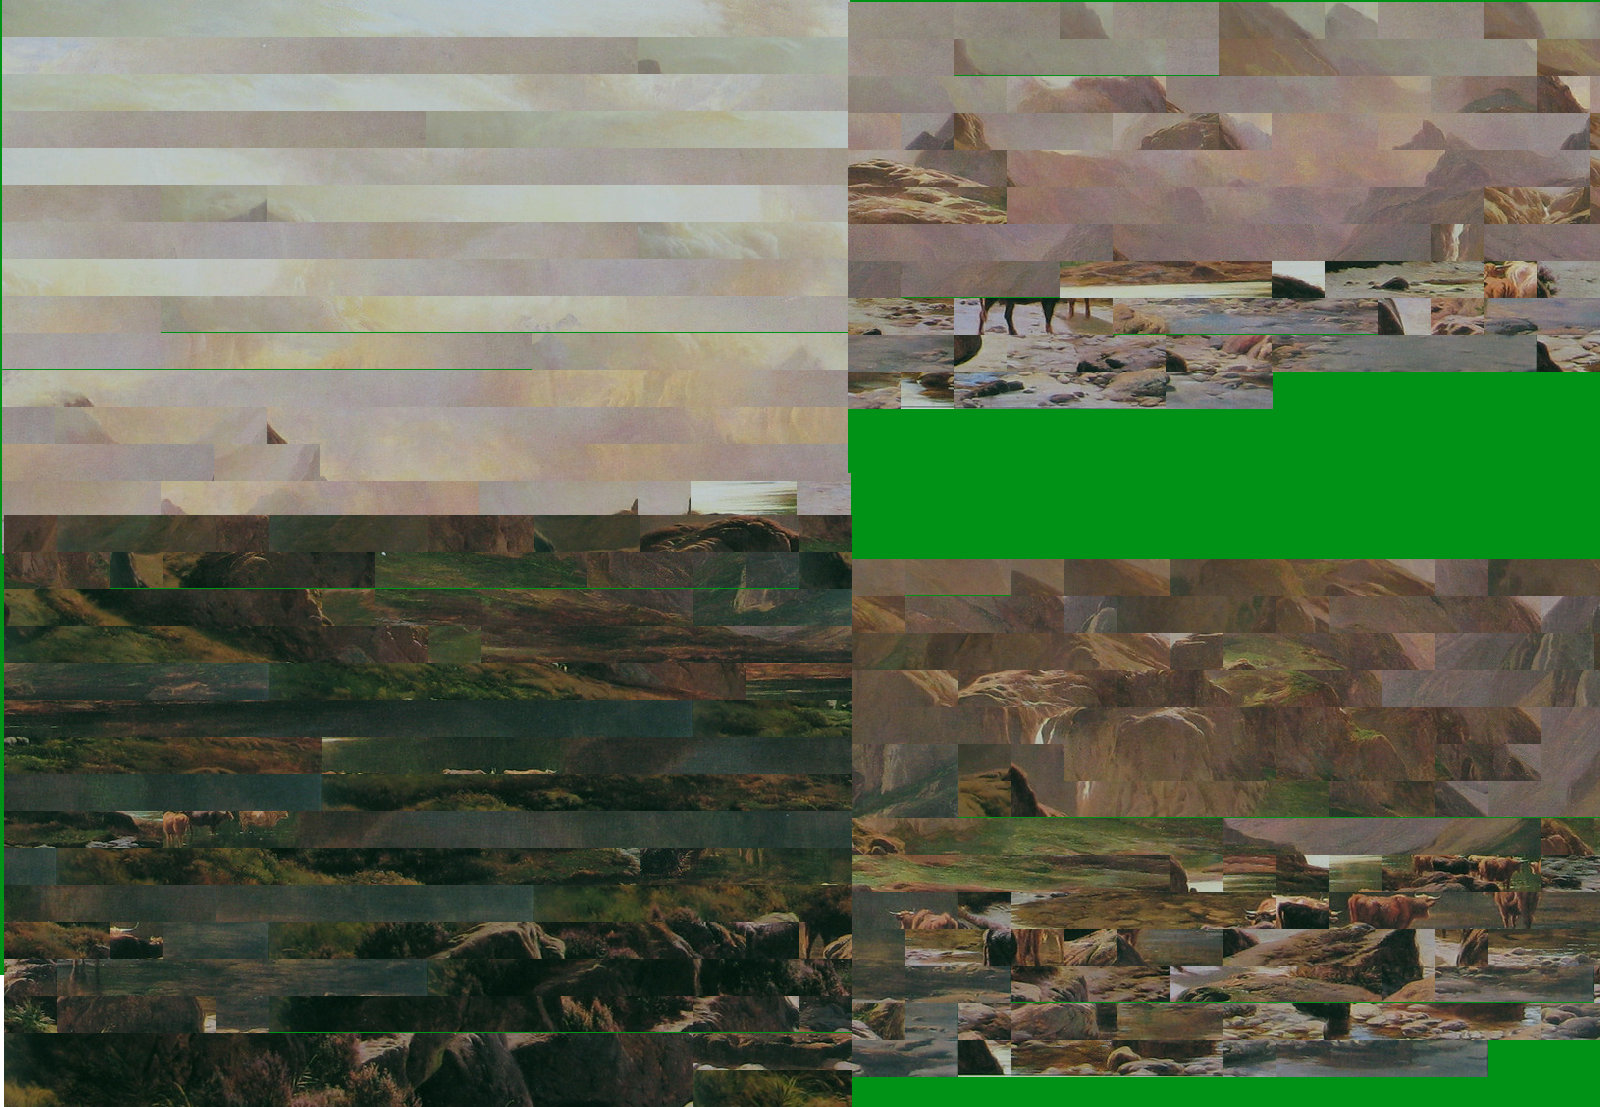

And for 16 clusters:
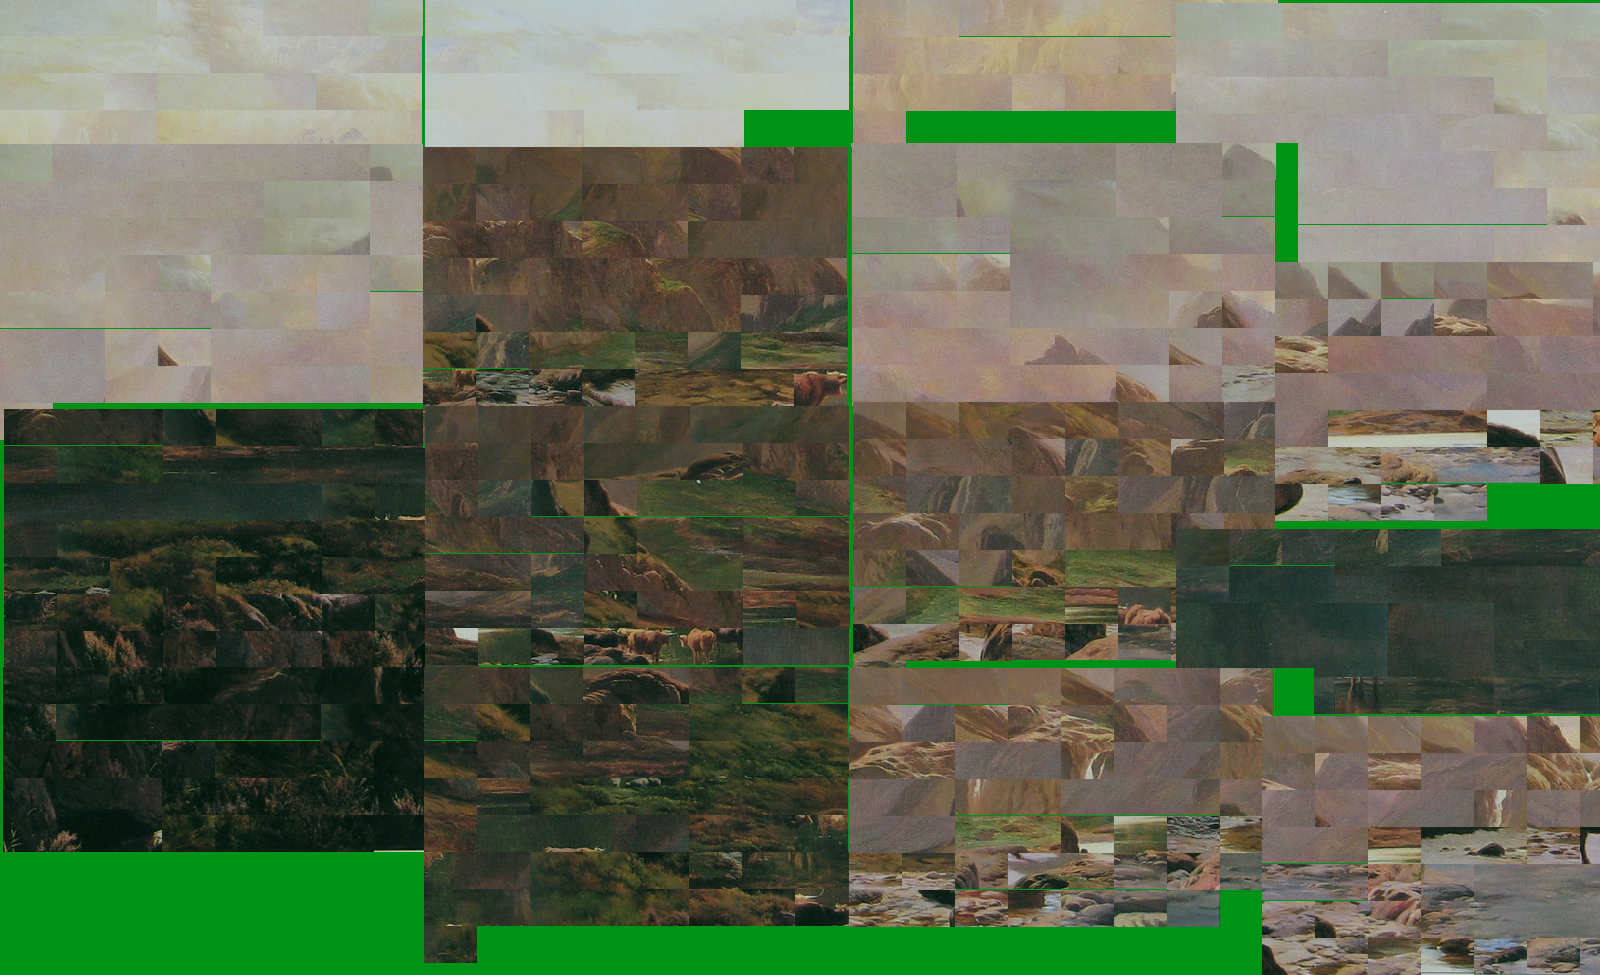

# Conclusion

The methods I used in this project had mixed results. Interestingly, I would subjectively rate the performance of the 4 cluster model better than the 16 cluster model, despite the 16 cluster model having a better score overall. If I were to do this again, the main thing I would want to do differently is to find another metric to evaluate the performance of the clustering model, or to produce the model in a way that would lend itself to a more conventional metric.

Another way to improve would be to find a more objective, and less arbitrary way to paste the clusters together. Ultimately, I simply put the parts together in a way that seemed more or less correct.